In [1]:
import warnings

warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd
from ResNN import ClassificationModel2 as ResNN, FocalLoss
import scipy.stats as st
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler, OneHotEncoder
from imblearn import over_sampling as osam, under_sampling as usam, combine as cbsam
import sdv
from sdv.sampling import Condition
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer, CopulaGANSynthesizer
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False

seed_everything()   

In [3]:
df = pd.read_csv('./impute_set/imp3.csv')

In [4]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.from_numpy(X.values).float()
        self.y = torch.from_numpy(y.values).long()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
def preprocessing(df):
    X = df.drop('BS3_1', axis=1)
    y = df['BS3_1']
    numeric_col = [
        'FEV1', 'FEV1FVC', 'age', 'BS6_3', 'BS6_2_1', 'BD1',
        '건강문해력', 'Total_slp_wk', 'EQ_5D', 'BE3_31', 'BE5_1', '질환유병기간'
    ]
    cat_col = []
    for col in X.columns:
        if col not in numeric_col:
            cat_col.append(col)

    df_num, df_cat = X[numeric_col], X[cat_col]
    n_pre = StandardScaler()
    df_num = pd.DataFrame(n_pre.fit_transform(df_num), columns=df_num.columns)

    c_pre = OrdinalEncoder()
    df_cat = pd.DataFrame(c_pre.fit_transform(df_cat), columns=df_cat.columns)
    
    X = pd.concat([df_num, df_cat], axis=1)
    return X, y

In [6]:
def test_with_imputations(train_loader, test_loader, test_y, input_dim, conf=True):
    ppreds, ttrue = None, None
    class_counts = torch.tensor([test_y.value_counts()[0], test_y.value_counts()[1]])
    class_weights = 1.0 / class_counts
    class_weights /= class_weights.sum()
    # print(class_weights)

    device = torch.device('cuda')
    # model = ResNN(input_dim=input_dim, hidden_dim=957, num_classes=2)
    model = ResNN(input_dim=input_dim, hidden_dim=608, num_classes=2)
    model = model.to(device)
    optim = Adam(model.parameters(), lr=.0001)
    class_counts = torch.tensor([test_y.value_counts()[0], test_y.value_counts()[1]])
    class_weights = 1.0 / class_counts
    class_weights /= class_weights.sum()
    
    criterion = FocalLoss(weight=class_weights.to(device))
    best_f1 = 0.0
    best_epoch = 0
    epochs=500
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xx, yy in train_loader:
            xx, yy = xx.to(device), yy.to(device)
            optim.zero_grad()
            preds = model(xx)
            loss = criterion(preds, yy)
            loss.backward()
            optim.step()
            running_loss += loss.item()
        model.eval()
        val_loss = 0
        correct = 0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for xx, yy in test_loader:
                xx, yy = xx.to(device), yy.to(device)
                preds = model(xx)
                val_loss = criterion(preds, yy).item()
                yy = yy.detach().cpu().numpy().squeeze()
                preds = preds.detach().cpu().numpy().squeeze()
                preds_labels = preds.argmax(axis=1)
                correct += (preds_labels == yy).sum().item()
                val_preds.extend(preds_labels.tolist())
                val_targets.extend(yy.tolist())

        val_loss /= len(test_loader)
        val_f1 = f1_score(val_targets, val_preds, average='macro')
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_epoch = epoch+1
            ppreds = val_preds
            ttrue = val_targets
            torch.save(model.state_dict(), 'bestResNN.pth')

    # print(f'Best Epoch: {best_epoch} | Best F1 : {best_f1:.4f}')
    if conf:
        return best_f1, ppreds, ttrue
    else:
        return best_f1

In [7]:
def test_with_5fold(df, over=False, method=None, n_folds=3):
    f1s = []
    pppreds = []
    tttrues = []
    X, y = preprocessing(df)
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    # rskf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    for train_idx, test_idx in rskf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        train_df = pd.concat([X_train, y_train], axis=0)
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        if over:
            if method == 'SMOTE':
                sampler = osam.SMOTE(random_state=42)
                X_train, y_train = sampler.fit_resample(X_train, y_train)
            elif method == 'ADASYN':
                sampler = osam.ADASYN(random_state=42)
                X_train, y_train = sampler.fit_resample(X_train, y_train)
            elif method == 'TOMEK':
                sampler = usam.TomekLinks()
                X_train, y_train = sampler.fit_resample(X_train, y_train)
            elif method == 'SMOTETomek':
                sampler = cbsam.SMOTETomek(random_state=42)
                X_train, y_train = sampler.fit_resample(X_train, y_train)
            elif method == 'GC':
                metadata = SingleTableMetadata()
                metadata.detect_from_dataframe(train_df)
                sampler = GaussianCopulaSynthesizer(metadata)
                sampler.fit(train_df)
                cond = Condition(
                    num_rows = y_train.value_counts()[1] - y_train.value_counts()[0], column_values={'BS3_1':0}
                )
                sample = sampler.sample_from_conditions(
                    conditions=[cond]
                )
                final_df = pd.concat([train_df, sample]).sample(frac=1, random_state=42).reset_index(drop=True)
                X_train = final_df.drop('BS3_1', axis=1)
                y_train = final_df['BS3_1']
            elif method == 'CTGAN':
                metadata = SingleTableMetadata()
                metadata.detect_from_dataframe(train_df)
                sampler = CTGANSynthesizer(metadata, epochs=100, verbose=True)
                sampler.fit(train_df)
                cond = Condition(
                    num_rows = y_train.value_counts()[1] - y_train.value_counts()[0], column_values={'BS3_1':0}
                )
                sample = sampler.sample_from_conditions(
                    conditions=[cond]
                )
                final_df = pd.concat([train_df, sample]).sample(frac=1, random_state=42).reset_index(drop=True)
                X_train = final_df.drop('BS3_1', axis=1)
                y_train = final_df['BS3_1']
            elif method == 'TVAE':
                metadata = SingleTableMetadata()
                metadata.detect_from_dataframe(train_df)
                sampler = TVAESynthesizer(metadata, epochs=1000, verbose=True)
                sampler.fit(train_df)
                cond = Condition(
                    num_rows = y_train.value_counts()[1] - y_train.value_counts()[0], column_values={'BS3_1':0}
                )
                sample = sampler.sample_from_conditions(
                    conditions=[cond]
                )
                final_df = pd.concat([train_df, sample]).sample(frac=1, random_state=42).reset_index(drop=True)
                X_train = final_df.drop('BS3_1', axis=1)
                y_train = final_df['BS3_1']
            elif method == 'CG':
                metadata = SingleTableMetadata()
                metadata.detect_from_dataframe(train_df)
                sampler = CopulaGANSynthesizer(metadata, epochs=100, verbose=True)
                sampler.fit(train_df)
                cond = Condition(
                    num_rows = y_train.value_counts()[1] - y_train.value_counts()[0], column_values={'BS3_1':0}
                )
                sample = sampler.sample_from_conditions(
                    conditions=[cond]
                )
                final_df = pd.concat([train_df, sample]).sample(frac=1, random_state=42).reset_index(drop=True)
                X_train = final_df.drop('BS3_1', axis=1)
                y_train = final_df['BS3_1']
            else:
                raise NotImplementedError
            

        train_set = CustomDataset(X_train, y_train)
        test_set = CustomDataset(X_test, y_test)
        g = torch.Generator()
        g.manual_seed(42)
        train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, generator=g)
        test_loader = DataLoader(test_set, batch_size=64, shuffle=True, pin_memory=True, generator=g)

        f1_value, ppreds, ttrue = test_with_imputations(
            train_loader, test_loader, y_test, input_dim=X_train.shape[-1], conf=True
        )
        f1s.append(f1_value)

        pppreds += ppreds
        tttrues += ttrue
    return f1s, pppreds, tttrues

def get_cv_results(f1s:list):
    f1s = np.array(f1s)
    mean_f1 = np.mean(f1s)
    std_f1 = np.std(f1s)
    ci95 = st.t.interval(.95, df=len(f1s)-1, loc=mean_f1, scale=std_f1/np.sqrt(len(f1s)))
    return mean_f1, std_f1, ci95


def bootstrap_ci(data, n_boot=1000, ci=95):
    boot_means = []
    for _ in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_means.append(np.mean(sample))
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return np.mean(data), np.std(data), (lower, upper)

In [8]:
f1s, ppreds, ttrues = test_with_5fold(df, over=True, method='SMOTE')
mean_f1, std_f1, ci95 = get_cv_results(f1s)
# print(f1s)
print(f'CV Results: Mean {mean_f1:.2f} | Std {std_f1:.2f} | CI95% {ci95[0]:.2f}~{ci95[1]:.2f}')

_, _, bci95 = bootstrap_ci(f1s)
print(f'Bootstrap CI95% {bci95[0]:.2f}~{bci95[1]:.2f}')

CV Results: Mean 0.81 | Std 0.06 | CI95% 0.78~0.85
Bootstrap CI95% 0.78~0.84


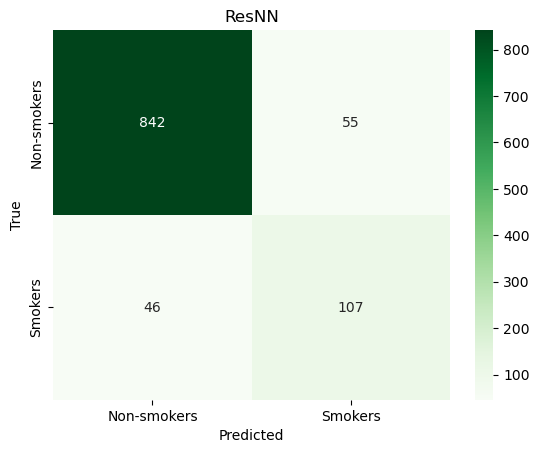

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.title('ResNN')
sns.heatmap(
    confusion_matrix(ttrues, ppreds), annot=True, fmt='.0f', 
    # xticklabels=['Smokers', 'Non-smokers'],
    # yticklabels=['Smokers', 'Non-smokers'],
    xticklabels=['Non-smokers', 'Smokers'],
    yticklabels=['Non-smokers', 'Smokers'],
    cmap='Greens'
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()